## Import av nødvendige moduler

In [1]:
import sys
src_path = "..\\src"
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from pandasql import sqldf

import functions as fc

### Hente inn og forberede data
Henter inn nedbørsdata fra relevante kolonner i en csv-fil, sjekker for manglende data samt endrer tidsreferansen til datetime-format. Sjekker hva høyeste og laveste verdi for nedbørsmendge i datasettet er.


Datasett over nedbørsmengde
   verdi tidsforskyvning              referansetid
0   10.4           PT18H  2024-01-01T00:00:00.000Z
1    6.3            PT6H  2024-01-01T00:00:00.000Z
2    3.1           PT18H  2024-01-02T00:00:00.000Z
3    6.4            PT6H  2024-01-02T00:00:00.000Z
4    1.2           PT18H  2024-01-03T00:00:00.000Z 

referansetid er gjort om til DateTime
   verdi tidsforskyvning              referansetid
0   10.4           PT18H 2024-01-01 00:00:00+00:00
1    6.3            PT6H 2024-01-01 00:00:00+00:00
2    3.1           PT18H 2024-01-02 00:00:00+00:00
3    6.4            PT6H 2024-01-02 00:00:00+00:00
4    1.2           PT18H 2024-01-03 00:00:00+00:00 

verdi              0
tidsforskyvning    0
referansetid       0
dtype: int64
Empty DataFrame
Columns: [verdi, tidsforskyvning, referansetid]
Index: []


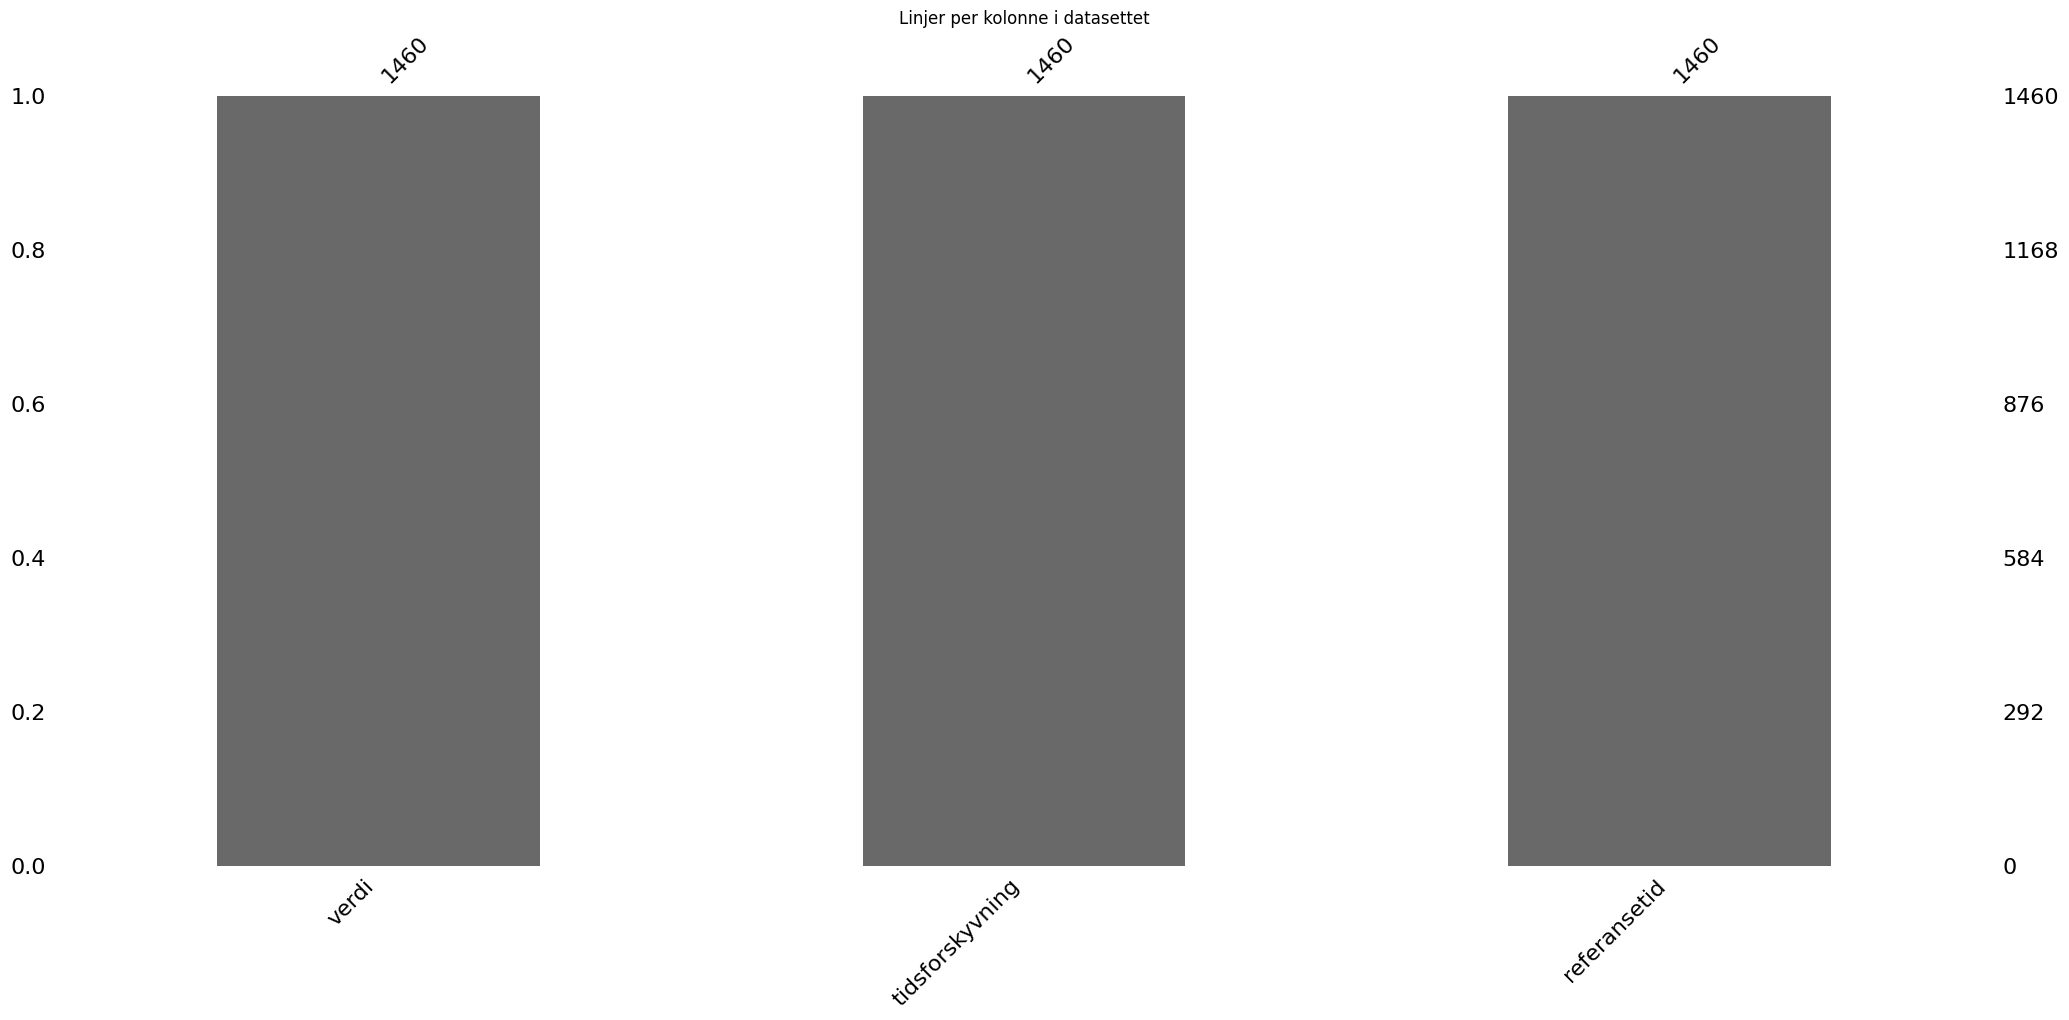

Den minste verdien er: 0.0
Den høyeste verdien er: 47.0


In [2]:
# Hente inn datasett fra data
precipitation = pd.read_csv("../data/precipitation.csv", usecols=['verdi', 'tidsforskyvning', 'referansetid'])
print('Datasett over nedbørsmengde')
print(precipitation.head(), '\n')

# Endre tidshenvisning til datetime-format
date = fc.make_datetime(precipitation)
print(precipitation.head(), '\n')

# Sjekker hvor mange av verdiene som mangler
fc.missing_numbers(precipitation)
plt.title("Linjer per kolonne i datasettet")
plt.show()

# Printer hva den høyeste og laveste verdien er 
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())

## Introdusere feil i datasettet
Fordi datasettet i utgangspunktet ikke inneholdt noen manglende eller ekstreme verdier, har vi valgt å introdusere disse så vi har mer å jobbe med siden. Vi har valgt å lagre de tilfeldig utvalgte linjene som endres i en seed, så vi har kontroll på hvilke linjer som blir byttet ut når vi kjører koden på nytt. Dette gjør det lettere å sammenligne resutlater fra andre endringer underveis.

In [3]:
# Lagrer de bestemte linjene i precipitation det går utover
np.random.seed(123)

# Velger 5 tilfeldige verdier ut i fra lengden på datasettet
numExtreme = 5
mod_indices = np.random.choice(len(precipitation), numExtreme, replace=False)

print(mod_indices)

# Velger så 5 verdier mellom 15 og 19 
extreme_value = np.random.randint(15, 20, len(mod_indices))
print(extreme_value)

# Ganger de valgte verdiene i precipitation med extreme_values
precipitation.loc[mod_indices, 'verdi'] *= extreme_value

# Lagrer den endrede dataframen i en ny fil 
precipitation.to_csv('../data/clean_precipitation.csv', index=False)
clean_prcp = pd.read_csv('../data/clean_precipitation.csv')

# Printer hva den høyeste og laveste verdien er
fc.min_max(precipitation)
fc.min_max(clean_prcp)


[ 147  676 1304 1372 1427]
[15 19 15 16 19]
Den minste verdien er: 0.0
Den høyeste verdien er: 222.4
Den minste verdien er: 0.0
Den høyeste verdien er: 222.4


## Visualisere resultater fra datasett med feil


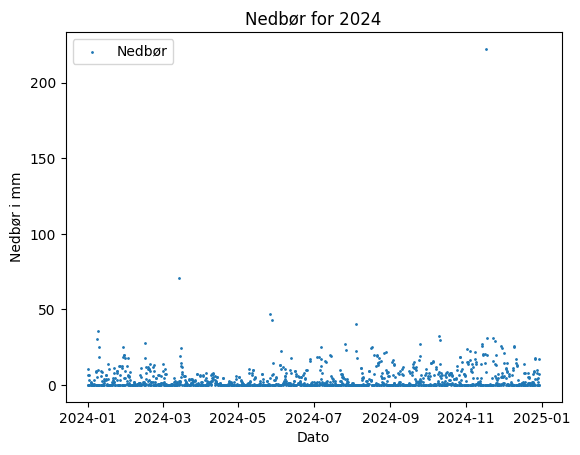

Gjennomsnittlig verdi for datasettet er 3.47
Medianen er 0.3


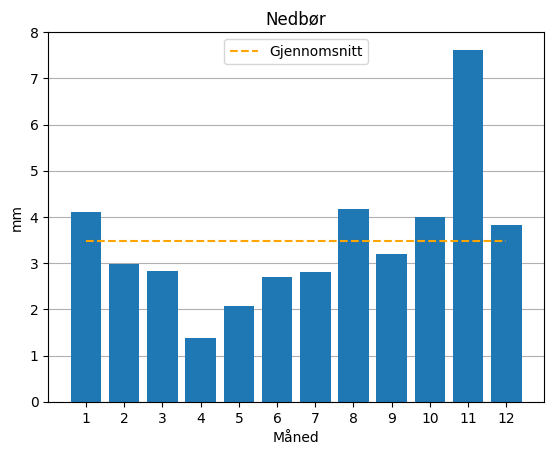

In [4]:
# Visualiserer datasettet med extreme verdier
plt.scatter(date, precipitation['verdi'], label="Nedbør", s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør i mm') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()


# Regne ut gjennomsnittlig nedbør over tid
fc.average_year(precipitation)
monthly_prcp = fc.average_other(precipitation, column='måned')

# Regne ut median
fc.median(precipitation)

# Visualisere månedlig gjennomsnitt
fc.average_month_bargraph(monthly_prcp, 'Nedbør', 'mm')

Skille ut ektreme verdier

Gjennomsnittlig verdi for datasettet er 3.47
Standardavviket er 8.38
      verdi tidsforskyvning              referansetid  måned
147    70.5            PT6H 2024-03-14 00:00:00+00:00      3
294    47.0           PT18H 2024-05-27 00:00:00+00:00      5
297    42.7            PT6H 2024-05-28 00:00:00+00:00      5
432    40.5           PT18H 2024-08-04 00:00:00+00:00      8
566    32.3           PT18H 2024-10-10 00:00:00+00:00     10
569    29.8            PT6H 2024-10-11 00:00:00+00:00     10
744    30.1           PT18H 2024-01-08 00:00:00+00:00      1
747    35.8            PT6H 2024-01-09 00:00:00+00:00      1
1372  222.4           PT18H 2024-11-17 00:00:00+00:00     11
1375   31.3            PT6H 2024-11-18 00:00:00+00:00     11
1384   30.8           PT18H 2024-11-23 00:00:00+00:00     11
1387   29.2            PT6H 2024-11-24 00:00:00+00:00     11


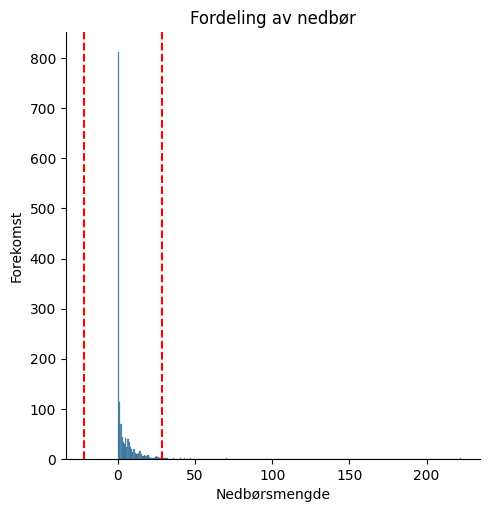

In [5]:
# Finner øvre og nedre grense
lower_limit, upper_limit = fc.lower_upper_limit(precipitation)

# Sier at de verdiene som er utenfor grensene lagres i outliers
outliers = precipitation[precipitation['verdi'].between(lower_limit, upper_limit) == False]
print(outliers) 

# Visualiserer datasettet med øvre og nedre grense 
plot = sns.displot(data=precipitation['verdi']).set(title="Fordeling av nedbør", xlabel="Nedbørsmengde", ylabel='Forekomst')
for ax in plot.axes.flat:
    ax.axvline(lower_limit, color='r', linestyle='--', label='Lower Limit')
    ax.axvline(upper_limit, color='r', linestyle='--', label='Upper Limit')


Fjerne ekstreme verdier

[70.5, 47.0, 42.7, 40.5, 32.3, 29.8, 30.1, 35.8, 222.4, 31.3, 30.8, 29.2]
Den minste verdien er: 0.0
Den høyeste verdien er: 28.0


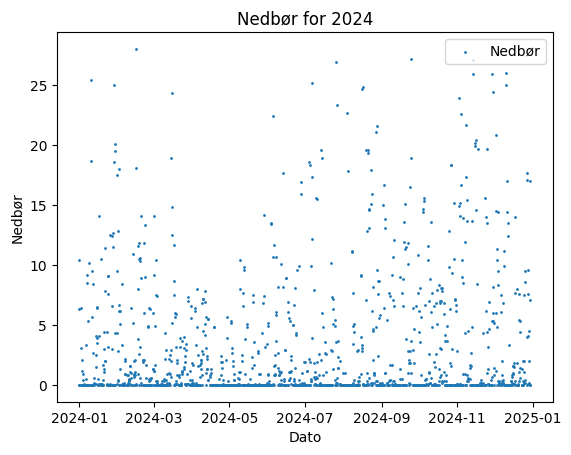

In [6]:
# Alle verdiene som er utenfor standardavviket legges i lista remove
remove = []
for i in outliers['verdi']:
    remove.append(i)
print(remove)

# Verdiene i precipitation som er lik verdiene i remove byttes ut med NaN
precipitation['verdi'] = precipitation['verdi'].replace(remove, np.nan)

# print den laveste og høyeste verdien for å vise at verdiene har endret seg
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())

# Visualiserer datasettet uten ekstreme verdier
plt.scatter(date, precipitation['verdi'], label="Nedbør", s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()


Få oversikt over manglende verdier i datasettet

verdi              12
tidsforskyvning     0
referansetid        0
måned               0
dtype: int64
      verdi tidsforskyvning              referansetid  måned
147     NaN            PT6H 2024-03-14 00:00:00+00:00      3
294     NaN           PT18H 2024-05-27 00:00:00+00:00      5
297     NaN            PT6H 2024-05-28 00:00:00+00:00      5
432     NaN           PT18H 2024-08-04 00:00:00+00:00      8
566     NaN           PT18H 2024-10-10 00:00:00+00:00     10
569     NaN            PT6H 2024-10-11 00:00:00+00:00     10
744     NaN           PT18H 2024-01-08 00:00:00+00:00      1
747     NaN            PT6H 2024-01-09 00:00:00+00:00      1
1372    NaN           PT18H 2024-11-17 00:00:00+00:00     11
1375    NaN            PT6H 2024-11-18 00:00:00+00:00     11
1384    NaN           PT18H 2024-11-23 00:00:00+00:00     11
1387    NaN            PT6H 2024-11-24 00:00:00+00:00     11


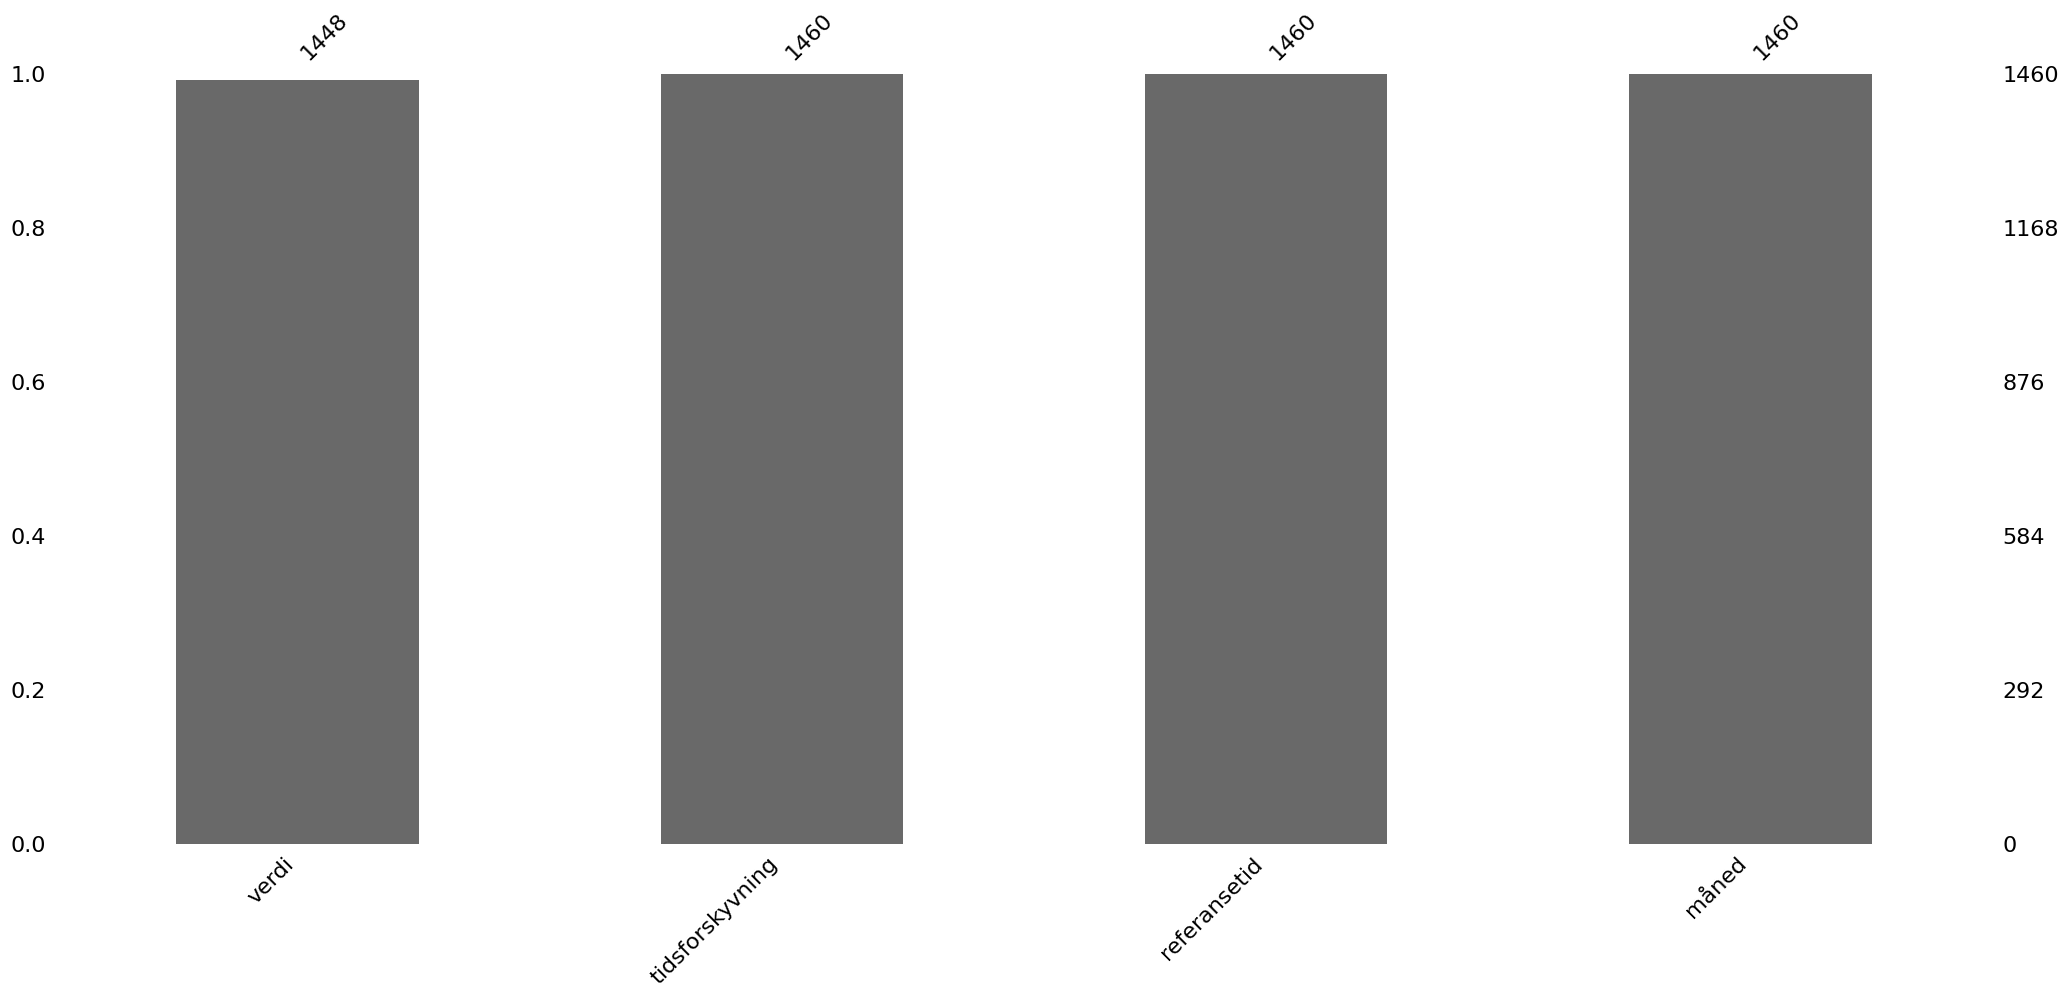

In [7]:
# Sjekker hvor mange og hvilke av verdiene som mangler
fc.missing_numbers(precipitation)

Fylle inn manglende verdier i datasettet

verdi              0
tidsforskyvning    0
referansetid       0
måned              0
dtype: int64
Empty DataFrame
Columns: [verdi, tidsforskyvning, referansetid, måned]
Index: []


C:\Users\runa_\AppData\Local\Temp\ipykernel_21940\3173948981.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)
C:\Users\runa_\AppData\Local\Temp\ipykernel_21940\3173948981.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)


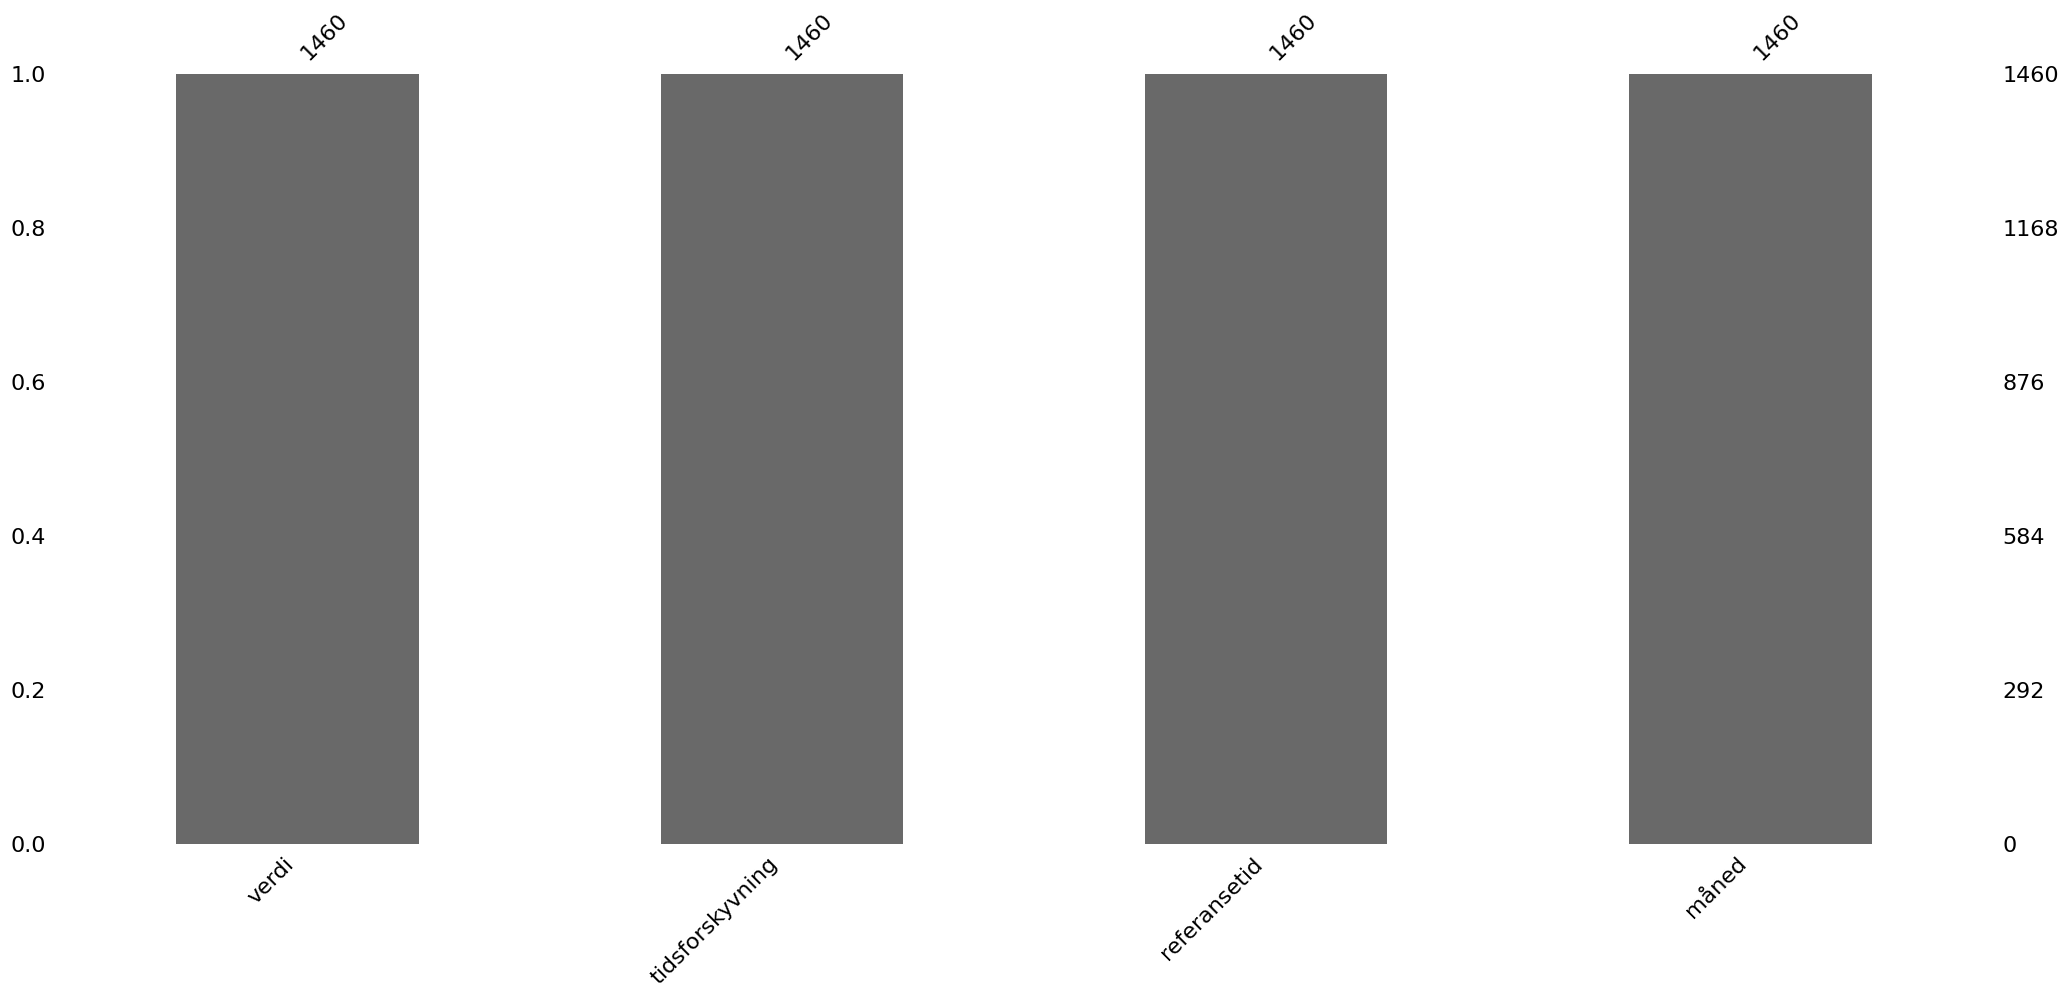

In [8]:
# Gjør NaN om til neste verdi i fila 
add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)

# Sjekker at verdiene er fylt inn
fc.missing_numbers(precipitation)

Testkode

måned
1     3.73
2     2.98
3     2.27
4     1.39
5     1.41
6     2.69
7     2.80
8     3.85
9     3.20
10    3.53
11    5.46
12    3.83
Name: verdi, dtype: float64


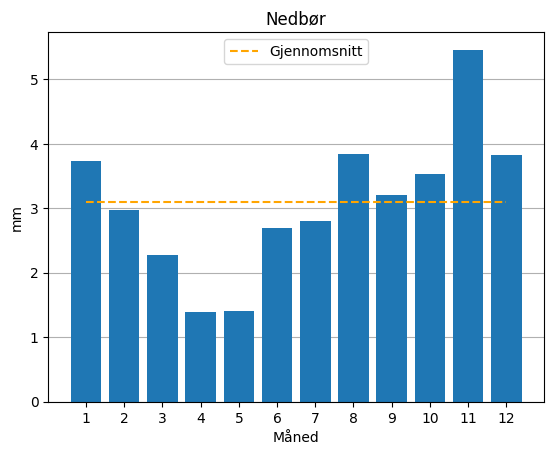

In [9]:
# Visualiserer de ulike tidsforskyvningene
fig = px.scatter(precipitation, 
                x= 'referansetid', 
                y= 'verdi',
                color= 'tidsforskyvning', 
                trendline= 'ols',
                )

fig.update_layout(title=dict(text='Precipitation')
)
fig.show()

# Finner gjennomsnittet for hver av tidsforskyvningene
gj_måned = fc.average_other(precipitation, column='måned')
print(gj_måned)

fc.average_month_bargraph(gj_måned, name='Nedbør',unit='mm')